## multi-to-multi step forecast

In [1]:
import os
import math
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

filename = 'dataset/shampoo-three-year.csv'

Using TensorFlow backend.


#### preprocessing for time-step forecasting

In [253]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용

참고:

original data
diff data
-->

266 145 183 119 ... 224
       -120  37  -63 ...   -7
       
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, split_index=12):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = split_index
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series,
                                                                                               x_steps=4, y_steps=3, split_index=17)
# transform original value to diff value
diff_interval = 1
diff_series = difference(origin_series, diff_interval)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, 
                                                                   x_steps=4, y_steps=3, split_index=17)

In [254]:
print('training X data shape:', origin_x_train.shape)
print('training Y data shape:', origin_y_train.shape)
print('test X data shape:', origin_x_test.shape)
print('test Y data shape:', origin_y_test.shape)

training X data shape: (17, 4)
training Y data shape: (17, 3)
test X data shape: (13, 4)
test Y data shape: (13, 3)


In [255]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (17, 4)
training Y data shape: (17, 3)
test X data shape: (12, 4)
test Y data shape: (12, 3)


In [256]:
# data reshape : for trim batch size (train, predict in Neural Networks)
x_train = x_train[:16, :]
y_train = y_train[:16, :]
x_test = x_test[:12, :]
y_test = y_test[:12, :]

In [257]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (16, 4)
training Y data shape: (16, 3)
test X data shape: (12, 4)
test Y data shape: (12, 3)


#### change shape for (LSTM or RNN)

In [258]:
"""
(size, timestep, feature) 의 형식으로 맞춰줘야 함
size : batch를 돌 데이터 사이즈
timestep : input의 time 개수 (X_t1, X_t2...)
feature : feature의 개수 (X = x1, x2 ...) [ex: x1 - 키, x2 - 몸무게 ...]
"""

time_step = 4
feature_num = 1

x_train_series = x_train.reshape(x_train.shape[0], time_step, feature_num)
x_test_series = x_test.reshape(x_test.shape[0], time_step, feature_num)

#### LSTM modeling code

In [259]:
num_epochs = 1800
batch_size=4
forecast_step = 3

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(forecast_step)) # output = forecast_step
model.compile(loss='mean_squared_error', optimizer='adam')

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train_series, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
16/16 [==============================] - 1s 74ms/step - loss: 0.2717
epochs : 1
Epoch 1/1
16/16 [==============================] - 0s 531us/step - loss: 0.2627
epochs : 2
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.2542
epochs : 3
Epoch 1/1
16/16 [==============================] - 0s 762us/step - loss: 0.2461
epochs : 4
Epoch 1/1
16/16 [==============================] - 0s 864us/step - loss: 0.2384
epochs : 5
Epoch 1/1
16/16 [==============================] - 0s 838us/step - loss: 0.2310
epochs : 6
Epoch 1/1
16/16 [==============================] - 0s 738us/step - loss: 0.2239
epochs : 7
Epoch 1/1
16/16 [==============================] - 0s 985us/step - loss: 0.2171
epochs : 8
Epoch 1/1
16/16 [==============================] - 0s 998us/step - loss: 0.2104
epochs : 9
Epoch 1/1
16/16 [==============================] - 0s 763us/step - loss: 0.2039
epochs : 10
Epoch 1/1
16/16 [==============================] - 0s 900us/step - loss: 0.1975
e

16/16 [==============================] - 0s 1ms/step - loss: 0.0347
epochs : 178
Epoch 1/1
16/16 [==============================] - 0s 689us/step - loss: 0.0347
epochs : 179
Epoch 1/1
16/16 [==============================] - 0s 961us/step - loss: 0.0347
epochs : 180
Epoch 1/1
16/16 [==============================] - 0s 775us/step - loss: 0.0346
epochs : 181
Epoch 1/1
16/16 [==============================] - 0s 746us/step - loss: 0.0346
epochs : 182
Epoch 1/1
16/16 [==============================] - 0s 734us/step - loss: 0.0346
epochs : 183
Epoch 1/1
16/16 [==============================] - 0s 748us/step - loss: 0.0346
epochs : 184
Epoch 1/1
16/16 [==============================] - 0s 684us/step - loss: 0.0346
epochs : 185
Epoch 1/1
16/16 [==============================] - 0s 671us/step - loss: 0.0346
epochs : 186
Epoch 1/1
16/16 [==============================] - 0s 725us/step - loss: 0.0345
epochs : 187
Epoch 1/1
16/16 [==============================] - 0s 705us/step - loss: 0.0345
ep

16/16 [==============================] - 0s 783us/step - loss: 0.0316
epochs : 354
Epoch 1/1
16/16 [==============================] - 0s 682us/step - loss: 0.0315
epochs : 355
Epoch 1/1
16/16 [==============================] - 0s 654us/step - loss: 0.0315
epochs : 356
Epoch 1/1
16/16 [==============================] - 0s 586us/step - loss: 0.0315
epochs : 357
Epoch 1/1
16/16 [==============================] - 0s 739us/step - loss: 0.0315
epochs : 358
Epoch 1/1
16/16 [==============================] - 0s 638us/step - loss: 0.0315
epochs : 359
Epoch 1/1
16/16 [==============================] - 0s 589us/step - loss: 0.0315
epochs : 360
Epoch 1/1
16/16 [==============================] - 0s 676us/step - loss: 0.0314
epochs : 361
Epoch 1/1
16/16 [==============================] - 0s 752us/step - loss: 0.0314
epochs : 362
Epoch 1/1
16/16 [==============================] - 0s 641us/step - loss: 0.0314
epochs : 363
Epoch 1/1
16/16 [==============================] - 0s 585us/step - loss: 0.0314


16/16 [==============================] - 0s 646us/step - loss: 0.0289
epochs : 530
Epoch 1/1
16/16 [==============================] - 0s 687us/step - loss: 0.0289
epochs : 531
Epoch 1/1
16/16 [==============================] - 0s 832us/step - loss: 0.0289
epochs : 532
Epoch 1/1
16/16 [==============================] - 0s 763us/step - loss: 0.0289
epochs : 533
Epoch 1/1
16/16 [==============================] - 0s 615us/step - loss: 0.0289
epochs : 534
Epoch 1/1
16/16 [==============================] - 0s 718us/step - loss: 0.0289
epochs : 535
Epoch 1/1
16/16 [==============================] - 0s 693us/step - loss: 0.0289
epochs : 536
Epoch 1/1
16/16 [==============================] - 0s 841us/step - loss: 0.0289
epochs : 537
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0289
epochs : 538
Epoch 1/1
16/16 [==============================] - 0s 631us/step - loss: 0.0288
epochs : 539
Epoch 1/1
16/16 [==============================] - 0s 805us/step - loss: 0.0288
ep

16/16 [==============================] - 0s 743us/step - loss: 0.0280
epochs : 706
Epoch 1/1
16/16 [==============================] - 0s 699us/step - loss: 0.0280
epochs : 707
Epoch 1/1
16/16 [==============================] - 0s 674us/step - loss: 0.0279
epochs : 708
Epoch 1/1
16/16 [==============================] - 0s 829us/step - loss: 0.0279
epochs : 709
Epoch 1/1
16/16 [==============================] - 0s 757us/step - loss: 0.0279
epochs : 710
Epoch 1/1
16/16 [==============================] - 0s 944us/step - loss: 0.0279
epochs : 711
Epoch 1/1
16/16 [==============================] - 0s 686us/step - loss: 0.0279
epochs : 712
Epoch 1/1
16/16 [==============================] - 0s 555us/step - loss: 0.0279
epochs : 713
Epoch 1/1
16/16 [==============================] - 0s 668us/step - loss: 0.0279
epochs : 714
Epoch 1/1
16/16 [==============================] - 0s 755us/step - loss: 0.0279
epochs : 715
Epoch 1/1
16/16 [==============================] - 0s 834us/step - loss: 0.0279


16/16 [==============================] - 0s 801us/step - loss: 0.0273
epochs : 882
Epoch 1/1
16/16 [==============================] - 0s 699us/step - loss: 0.0273
epochs : 883
Epoch 1/1
16/16 [==============================] - 0s 611us/step - loss: 0.0273
epochs : 884
Epoch 1/1
16/16 [==============================] - 0s 739us/step - loss: 0.0273
epochs : 885
Epoch 1/1
16/16 [==============================] - 0s 596us/step - loss: 0.0273
epochs : 886
Epoch 1/1
16/16 [==============================] - 0s 720us/step - loss: 0.0273
epochs : 887
Epoch 1/1
16/16 [==============================] - 0s 693us/step - loss: 0.0273
epochs : 888
Epoch 1/1
16/16 [==============================] - 0s 613us/step - loss: 0.0273
epochs : 889
Epoch 1/1
16/16 [==============================] - 0s 659us/step - loss: 0.0273
epochs : 890
Epoch 1/1
16/16 [==============================] - 0s 719us/step - loss: 0.0273
epochs : 891
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0273
ep

16/16 [==============================] - 0s 1ms/step - loss: 0.0266
epochs : 1057
Epoch 1/1
16/16 [==============================] - 0s 649us/step - loss: 0.0266
epochs : 1058
Epoch 1/1
16/16 [==============================] - 0s 699us/step - loss: 0.0266
epochs : 1059
Epoch 1/1
16/16 [==============================] - 0s 723us/step - loss: 0.0266
epochs : 1060
Epoch 1/1
16/16 [==============================] - 0s 527us/step - loss: 0.0266
epochs : 1061
Epoch 1/1
16/16 [==============================] - 0s 701us/step - loss: 0.0266
epochs : 1062
Epoch 1/1
16/16 [==============================] - 0s 700us/step - loss: 0.0266
epochs : 1063
Epoch 1/1
16/16 [==============================] - 0s 596us/step - loss: 0.0266
epochs : 1064
Epoch 1/1
16/16 [==============================] - 0s 629us/step - loss: 0.0266
epochs : 1065
Epoch 1/1
16/16 [==============================] - 0s 597us/step - loss: 0.0266
epochs : 1066
Epoch 1/1
16/16 [==============================] - 0s 763us/step - loss:

16/16 [==============================] - 0s 674us/step - loss: 0.0258
epochs : 1231
Epoch 1/1
16/16 [==============================] - 0s 544us/step - loss: 0.0258
epochs : 1232
Epoch 1/1
16/16 [==============================] - 0s 625us/step - loss: 0.0258
epochs : 1233
Epoch 1/1
16/16 [==============================] - 0s 698us/step - loss: 0.0258
epochs : 1234
Epoch 1/1
16/16 [==============================] - 0s 846us/step - loss: 0.0258
epochs : 1235
Epoch 1/1
16/16 [==============================] - 0s 783us/step - loss: 0.0258
epochs : 1236
Epoch 1/1
16/16 [==============================] - 0s 655us/step - loss: 0.0258
epochs : 1237
Epoch 1/1
16/16 [==============================] - 0s 648us/step - loss: 0.0258
epochs : 1238
Epoch 1/1
16/16 [==============================] - 0s 574us/step - loss: 0.0258
epochs : 1239
Epoch 1/1
16/16 [==============================] - 0s 994us/step - loss: 0.0258
epochs : 1240
Epoch 1/1
16/16 [==============================] - 0s 624us/step - los

16/16 [==============================] - 0s 677us/step - loss: 0.0253
epochs : 1405
Epoch 1/1
16/16 [==============================] - 0s 769us/step - loss: 0.0253
epochs : 1406
Epoch 1/1
16/16 [==============================] - 0s 698us/step - loss: 0.0253
epochs : 1407
Epoch 1/1
16/16 [==============================] - 0s 880us/step - loss: 0.0253
epochs : 1408
Epoch 1/1
16/16 [==============================] - 0s 635us/step - loss: 0.0253
epochs : 1409
Epoch 1/1
16/16 [==============================] - 0s 645us/step - loss: 0.0253
epochs : 1410
Epoch 1/1
16/16 [==============================] - 0s 713us/step - loss: 0.0253
epochs : 1411
Epoch 1/1
16/16 [==============================] - 0s 643us/step - loss: 0.0253
epochs : 1412
Epoch 1/1
16/16 [==============================] - 0s 736us/step - loss: 0.0253
epochs : 1413
Epoch 1/1
16/16 [==============================] - 0s 747us/step - loss: 0.0253
epochs : 1414
Epoch 1/1
16/16 [==============================] - 0s 733us/step - los

16/16 [==============================] - 0s 693us/step - loss: 0.0249
epochs : 1579
Epoch 1/1
16/16 [==============================] - 0s 770us/step - loss: 0.0249
epochs : 1580
Epoch 1/1
16/16 [==============================] - 0s 743us/step - loss: 0.0249
epochs : 1581
Epoch 1/1
16/16 [==============================] - 0s 676us/step - loss: 0.0249
epochs : 1582
Epoch 1/1
16/16 [==============================] - 0s 622us/step - loss: 0.0249
epochs : 1583
Epoch 1/1
16/16 [==============================] - 0s 720us/step - loss: 0.0249
epochs : 1584
Epoch 1/1
16/16 [==============================] - 0s 693us/step - loss: 0.0249
epochs : 1585
Epoch 1/1
16/16 [==============================] - 0s 643us/step - loss: 0.0249
epochs : 1586
Epoch 1/1
16/16 [==============================] - 0s 563us/step - loss: 0.0249
epochs : 1587
Epoch 1/1
16/16 [==============================] - 0s 697us/step - loss: 0.0249
epochs : 1588
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss:

16/16 [==============================] - 0s 1ms/step - loss: 0.0246
epochs : 1753
Epoch 1/1
16/16 [==============================] - ETA: 0s - loss: 0.020 - 0s 918us/step - loss: 0.0246
epochs : 1754
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0246
epochs : 1755
Epoch 1/1
16/16 [==============================] - 0s 685us/step - loss: 0.0246
epochs : 1756
Epoch 1/1
16/16 [==============================] - 0s 511us/step - loss: 0.0246
epochs : 1757
Epoch 1/1
16/16 [==============================] - 0s 641us/step - loss: 0.0246
epochs : 1758
Epoch 1/1
16/16 [==============================] - 0s 724us/step - loss: 0.0246
epochs : 1759
Epoch 1/1
16/16 [==============================] - 0s 668us/step - loss: 0.0246
epochs : 1760
Epoch 1/1
16/16 [==============================] - 0s 666us/step - loss: 0.0246
epochs : 1761
Epoch 1/1
16/16 [==============================] - 0s 680us/step - loss: 0.0246
epochs : 1762
Epoch 1/1
16/16 [==============================] -

In [260]:
# get RMSE
train_predict = model.predict(x_train_series, batch_size=batch_size)
diff_predict = scaler.inverse_transform(train_predict)
# diff_predict = scaler.inverse_transform(y_train)
restored_predict = diff_predict + origin_y_train[0:diff_predict.shape[0]]

# diff value와는 diff_interval만큼 데이터 개수의 차이가 있음. 
# original data에서 앞의 diff_interval만큼을 빼면 같은 크기, 같은 위치의 데이터가 됨.
origin_y_train_series = origin_y_train[diff_interval:]

train_score = math.sqrt(mean_squared_error(restored_predict, origin_y_train_series))
print('Train score : RMSE: %f' % train_score)
for i in range(forecast_step):
    actual = [row[i] for row in origin_y_train_series]
    predict = [forecast[i] for forecast in restored_predict]
    rmse = math.sqrt(mean_squared_error(actual, predict))
    print('Train score : t+%d RMSE: %f' % ((i+1), rmse))

model.reset_states()
    

# get RMSE
test_predict = model.predict(x_test_series, batch_size=batch_size)
# diff_predict = scaler.inverse_transform(y_test)
diff_predict = scaler.inverse_transform(test_predict)
restored_predict = diff_predict + origin_y_test[0:diff_predict.shape[0]]
origin_y_test_series = origin_y_test[diff_interval:restored_predict.shape[0]+1]

test_score = math.sqrt(mean_squared_error(restored_predict, origin_y_test_series))
print('Test score : RMSE: %f' % test_score)
for i in range(forecast_step):
    actual = [row[i] for row in origin_y_test_series]
    predict = [forecast[i] for forecast in restored_predict]
    rmse = math.sqrt(mean_squared_error(actual, predict))
    print('Test score : t+%d RMSE: %f' % ((i+1), rmse))
    
model.reset_states()

Train score : RMSE: 75.269394
Train score : t+1 RMSE: 46.427200
Train score : t+2 RMSE: 81.809587
Train score : t+3 RMSE: 90.267112
Test score : RMSE: 121.597741
Test score : t+1 RMSE: 105.314959
Test score : t+2 RMSE: 120.124922
Test score : t+3 RMSE: 137.247202


In [261]:
def show_train_fit(origin_y_train):
    train_predict = model.predict(x_train_series, batch_size=batch_size)
    yhat = scaler.inverse_transform(train_predict) 
#     yhat = scaler.inverse_transform(y_train) # 예측 말고 train 값 볼때
    yhat = yhat + origin_y_train[0:yhat.shape[0]]
    model.reset_states()
    return yhat

# def get_recent_prediction():
#     output = model.predict(x_train_series, batch_size=batch_size)
#     prediction = output[output.shape[0]-1]
#     yhat = [scaler.inverse_transform(x) for x in prediction]
#     model.reset_states()
#     return yhat

(16, 3)
(16,)


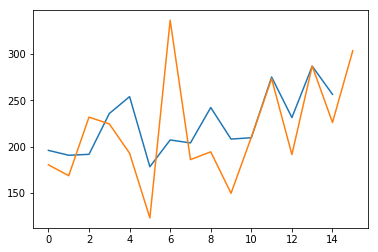

In [262]:
predictions = show_train_fit(origin_y_train)

print(predictions.shape)
print(origin_y_train[:predictions.shape[0], 0].shape)
plt.plot(predictions[diff_interval:, 0]) # y_hat : blue line. t만 관찰.
plt.plot(origin_y_train[:predictions.shape[0], 0]) # y_train_origin : yellow line. t만 관찰.
plt.show()

# print(get_recent_prediction())

In [263]:
def show_test_fit(origin_y_test):
    test_predict = model.predict(x_test_series, batch_size=batch_size)
    yhat = scaler.inverse_transform(test_predict) 
#     yhat = scaler.inverse_transform(y_train) # 예측 말고 train 값 볼때
    yhat = yhat + origin_y_test[0:yhat.shape[0]]
    model.reset_states()
    return yhat

(12, 3)
(12,)


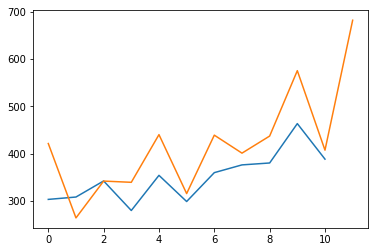

In [264]:
predictions = show_test_fit(origin_y_test)

print(predictions.shape)
print(origin_y_test[:predictions.shape[0], 0].shape)
plt.plot(predictions[diff_interval:, 0]) # y_hat : blue line. t만 관찰.
plt.plot(origin_y_test[:predictions.shape[0], 0]) # y_train_origin : yellow line. t만 관찰.
plt.show()

# print(get_recent_prediction())

## Bitcoin dataset

https://www.blockchain.com/ko/charts/market-price?timespan=60days

### check data

In [14]:
filename = "dataset/market-price.csv"
market = pd.read_csv(filename, header=None)

In [15]:
market.head()

,0,1
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000


In [16]:
print(market.shape)
print(market.columns)

(365, 2)
Int64Index([0, 1], dtype='int64')


### data preprocessing

In [17]:
market.columns = ['day', 'price']
market.head()

,day,price
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000


In [18]:
market.day = market.day.apply(lambda x: x[:10])

### make splited timeseries data

In [ ]:
market.index = market['day']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용

참고:

original data
diff data
-->

266 145 183 119 ... 224
       -120  37  -63 ...   -7
       
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, split_index=12):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = split_index
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series,
                                                                                               x_steps=4, y_steps=3, split_index=17)
# transform original value to diff value
diff_interval = 1
diff_series = difference(origin_series, diff_interval)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, 
                                                                   x_steps=4, y_steps=3, split_index=17)